In [411]:
from bert_serving.client import BertClient
import numpy as np
import pandas as pd
import nltk
Porter = nltk.stem.PorterStemmer()
import csv
import pickle
import re
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy import spatial
import pickle

In [2]:
def readfile(filename,method='utf-8'):
    rawlist = []
    with open(filename,'r+', encoding=method) as csvfile:
        rows = csv.reader(csvfile)
        for row in rows:
            rawlist.append(row)
    return rawlist

def writefile(filename,inputlist,method='utf-8'):
    with open(filename,'a+', encoding=method) as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        for row in inputlist:
            writer.writerow(row)
            
def regex(a):
    reg = []
    #a = re.sub('[a-zA-Z]','',a)
    a = re.sub('[,、：；！？，。－"\']','#',a)
    a = re.sub('[「」(){}:;!?]','',a)
    a = re.sub('\n','',a)
    #a = re.sub('[(),{}\u3000\*\|=-\[\]\n.]','',a)
    #a = re.sub(u"\\（.*?\\）|\\『.*?』|\\「.*?」|\\〔.*?〕|\\[.*?]|\\〈.*?〉", '', a)
    reg = a.split('#')
    return reg

def en_regex(a):
    #a = re.sub('[a-zA-Z]','',a)
    a = re.sub('[(){}.:,;!?：；！？，。－"\']','',a)
    #a = re.sub(',',' ',a)
    #a = re.sub('\n','',a)
    #a = re.sub('[(),{}\u3000\*\|=-\[\]\n.]','',a)
    #a = re.sub(u"\\（.*?\\）|\\『.*?』|\\「.*?」|\\〔.*?〕|\\[.*?]|\\〈.*?〉", '', a)
    if not a.find('to ')==-1:
        a = a[a.find('to ')+3:]
    return a

def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [198]:
bc = BertClient()

In [3]:
adictsrc = readfile('zh_en_dict.csv')
adict = dict()
for i in range(0,len(adictsrc)):
    adict[adictsrc[i][0]] = adictsrc[i][1:]
len(adict)

114442

In [4]:
with open('bertvectors1.pickle', 'rb') as file:
    tmpd1 = pickle.load(file)
with open('bertvectors2.pickle', 'rb') as file:
    tmpd2 = pickle.load(file)
with open('bertvectors3.pickle', 'rb') as file:
    tmpd3 = pickle.load(file)
with open('bertvectors4.pickle', 'rb') as file:
    tmpd4 = pickle.load(file)
bertvectors = {**tmpd1, **tmpd2, **tmpd3, **tmpd4}

In [330]:
with open('chinese_bertvectors.pickle', 'rb') as file:
    chinese_bertvectors = pickle.load(file)

In [5]:
chcut = []
with (open('chcut.pickle', "rb")) as openfile:
    chcut = pickle.load(openfile)
encut = []
with (open('encut.pickle', "rb")) as openfile:
    encut = pickle.load(openfile)

In [6]:
with open('chvector.pickle', 'rb') as file:
    chvector = pickle.load(file)
with open('envector.pickle', 'rb') as file:
    envector = pickle.load(file)

In [7]:
ch_dic = []
for i in range(0,len(chcut)):
    for j in range(0,len(chcut[i])):
        for word in chcut[i][j]:
            if word not in ch_dic:
                ch_dic.append(word)

In [11]:
pairs = []
for word in ch_dic:
    try:
        means = adict[word]
    except:
        continue
    if len(means)==1 and isEnglish(means[0]) and len(means[0])>=2:
        tmp = en_regex(means[0]).strip()
        if not len(tmp.split())>3 and not len(tmp)>20:
            pairs.append([word,tmp])

In [17]:
chinese_numbers = ['一','二','三','四','五','六','七','八','九']
pairs = sorted(pairs)
for line in pairs:
    if line[0] in chinese_numbers:
        print(line)

['七', 'seven']
['三', 'three']
['九', 'nine']
['五', 'five']
['八', 'eight']
['六', 'six']
['四', 'four']


In [24]:
pairvector = []
for i in range(0,len(pairs)):
    if not pairs[i][1] == '':
        ch = chvector[pairs[i][0]]
        en = envector[pairs[i][1]]
        #en = bc.encode([pairs[i][1]])
    pairvector.append([ch,en,pairs[i][0],pairs[i][1]])

In [25]:
chcombined = pairvector[0][0]
encombined = pairvector[0][1]
for i in range(1,len(pairvector)):
    chcombined = np.append(chcombined,pairvector[i][0],axis=0)
print(type(chcombined[1]))
for i in range(1,len(pairvector)):
    encombined = np.append(encombined,pairvector[i][1],axis=0)
print(type(encombined[1]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [331]:
def cal_cost(theta,X,y,method='MSE'):
    m = len(y)
    cost = 0
  
    if method == 'ED':
        #eucilidean distance
        for i in range(m):
            cost = cost + np.sqrt(np.sum(np.square(np.dot(X[i],theta) - y[i])))
            #print(cost)
        #print('XXX')
        cost = 1/(2*m)*cost
    else:
        y_pred = []
        for i in range(m):
            y_pred.append(np.dot(X[i],theta))
        mse = mean_squared_error(y, y_pred)
        cost = np.sum(mse)
    return cost

In [332]:
def gradient_descent(X,y,theta,learning_rate=0.01,iterations=100):
    m = len(y)
    print('訓練資料組數 =',m)
    cost_history = np.zeros(iterations)
    #theta_history = np.zeros((iterations,768,768))
    for it in range(iterations):
        prediction = np.dot(X,theta)
        result = prediction-y
        theta = theta - (1/m)*learning_rate*(np.dot(X.T,result))   
        #theta_history[it,:] = theta.T
        cost_history[it]  = cal_cost(theta,X,y)   
    #return theta, cost_history, theta_history
    return theta, cost_history

In [431]:
#theta = np.random.randn(768,768)
theta = np.zeros((768,768))
head = random.randint(0,852)
tail = head+1000
print(head,tail)
trans_matrix, cost_history = gradient_descent(chcombined[:],encombined[:],theta,0.001,5000)

422 1422
訓練資料組數 = 1851


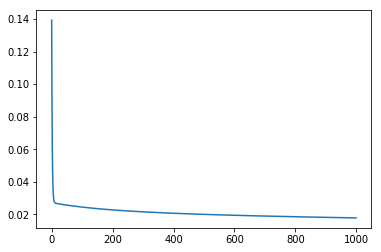

In [291]:
plt.plot(cost_history)

In [293]:
#Best For Now
trans_matrix2, cost_history = gradient_descent(chcombined[:100],encombined[:100],theta,0.001,1000)

In [305]:
chinese_numbers = ['四','五','六','七','八','九']
chinese_name = ['4','5','6','7','8','9']

target_vector = ['紅色','綠色','藍色','黃色','紫色','白色','黑色','橙色']
target_vectorname = ['red','green','blue','yellow','purple','white','black','orange']


target_vector = ['四','五','六','七','八','九']
target_vectorname = ['4','5','6','7','8','9']

#target_vector = ['我','你','他','它']
target_vector2 = ['今天','明天','後天','昨天']

In [295]:
pre = []
pairs = sorted(pairs)
print("%s  %s   %4s  %8s %4s" % ('ch','en','init','baseline','exp'))
print('-----------------------------')
for line in pairvector:
    if line[2] in chinese_numbers:
        #print(line[2])
        pre2 = np.dot(line[0],trans_matrix2)
        pre = np.dot(line[0],trans_matrix)
        originalstat = 1-spatial.distance.cosine(line[0],line[1])
        teststat2 = 1-spatial.distance.cosine(pre2,line[1])
        teststat = 1-spatial.distance.cosine(pre,line[1])
        print("%s%6s %.4f %.4f %.4f" % (line[2],line[3],originalstat,teststat2,teststat))
        #print(line[2],line[3],originalstat,teststat)


ch  en   init  baseline  exp
-----------------------------
七 seven 0.0644 0.9392 0.9871
三 three 0.0135 0.9071 0.7556
九  nine 0.0806 0.9359 0.9863
五  five 0.0237 0.8993 0.7213
八 eight 0.0233 0.8418 0.7284
六   six 0.0708 0.9357 0.9873
四  four 0.0237 0.9211 0.7931


In [309]:
def draw_scatter_plot(Df,tag,col='yellow'):
    plt.subplots_adjust(bottom = 0.1)
    plt.scatter(Df['component 1'], Df['component 2'])
    for label, x, y in zip(tag,Df['component 1'],Df['component 2']):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc=col, alpha=0.5),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    plt.show()

In [436]:
def scatter_plot_experiment(pairvector,target,tag,trans_matrix):
    pca = PCA(n_components=2)
    ev = np.zeros([1,768])
    cv = np.zeros([1,768])
    for line in pairvector:
        if line[2] in target:
            ev = np.append(ev,line[1],axis=0)
            cv = np.append(cv,np.dot(line[0],trans_matrix),axis=0)
    ev = np.delete(ev,1,0)
    cv = np.delete(cv,1,0)
    evpca = pca.fit_transform(ev)
    cvpca = pca.fit_transform(cv)
    #evpca = preprocessing.scale(evpca)
    #cvpca = preprocessing.scale(cvpca)
    evDf = pd.DataFrame(data = evpca,columns = ['component 1', 'component 2'])
    cvDf = pd.DataFrame(data = cvpca,columns = ['component 1', 'component 2'])
    draw_scatter_plot(evDf,tag)
    draw_scatter_plot(cvDf,tag,'blue')

In [401]:
def precision_at_5_experiment(target,pairvector,trans_matrix):
    pca = PCA(n_components=2)
    cv = []
    output = []
    noutput = []
    for word in target:
        for i in range(0,len(pairvector)):
            if word == pairvector[i][2]:
                vec = chinese_bertvectors[word]
                cv.append(np.dot(vec,trans_matrix))
                break
        
    for i in range(0,len(cv)):
        for j in range(0,len(pairvector)): 
            cos = 1-spatial.distance.cosine(cv[i],pairvector[j][1])
            output.append([cos,pairvector[j][3]])
        output = sorted(output,reverse=True)
        for x in range(0,len(output)):
            if not output[x][1] == output[x-1][1]:
                noutput.append(output[x]) 
        print(target[i])
        for x in range(0,10):
            print(noutput[x])
        output = []
        noutput = []

In [433]:
tvec = ['中國','中華','臺北','臺灣','台北','台北市','頭部','頸','鼻炎','臉部']
tvec = ['你','公里']
precision_at_5_experiment(tvec,new_pairvector,trans_matrix)

你
[0.9854154600310218, 'zinc']
[0.9854154600310218, 'yttrium']
[0.9854154600310218, 'you informal']
[0.9854154600310218, 'you courteous']
[0.9854154600310218, 'yes']
[0.9854154600310218, 'woolen material']
[0.9854154600310218, 'which interrogative']
[0.9854154600310218, 'vacation']
[0.9854154600310218, 'two']
[0.9854154600310218, 'tutor']
公里
[0.959742992179294, 'head']
[0.959742992179294, 'bottom']
[0.9561938940498488, 'survey and evaluate']
[0.9561938940498488, 'specified capacity']
[0.9561938940498488, 'schedule in advance']
[0.9561938940498488, 'constant']
[0.9554643794842534, 'public']
[0.9554643794842534, 'meter']
[0.9554643794842534, 'liter']
[0.9554643794842534, 'formula']


In [418]:
cost = 0
for i in range(0,len(pairvector)):
    if pairvector[i][2] == '台北':
        #cost = cost + np.sqrt(np.sum(np.square(np.dot(pairvector[i][0],trans_matrix) - pairvector[i][1])))
        #print(cost)
        tmp = np.dot(pairvector[i][0],trans_matrix)
        print(1-spatial.distance.cosine(tmp,pairvector[i][1]))

0.9486229816844303


In [434]:
tmp2 = 0
tmp = 0
for i in range(0,len(pairvector)):
    #print(pairvector[i][2])
    if pairvector[i][3] == 'cooling water':
        tmp = pairvector[i][1]
    elif pairvector[i][2] == '台北':
        tmp2 = pairvector[i][1]   
print(1-spatial.distance.cosine(tmp2,tmp))

0.9168239831924438


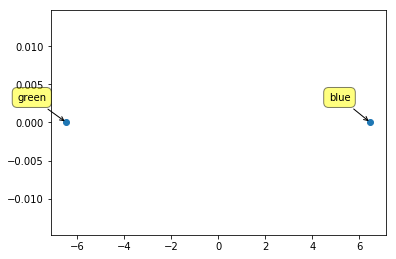

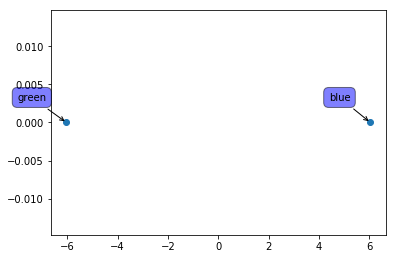

In [438]:
tvec = ['中國','中華','臺北','臺灣','台北','台北市','頭部','頸','鼻炎','臉部']
tags = ['prc','roc','tpe','tw','tpe2','tpecity','head','neck','ill','face']
#tvec = ['頭部','頸','鼻炎','臉部']
tvec = ['綠色','藍色']
tags = ['green','blue']
#tags = ['head','neck','ill','face']
scatter_plot_experiment(pairvector,tvec,tags,trans_matrix)

In [36]:
cost_collection = []
theta = np.zeros((768,768))

for i in range(1,10):
    trans_matrix, cost_history, theta_history = gradient_descent(chcombined[:100*i],encombined[:100*i],theta,0.001,1000)
    cost_collection.append(cost_history)

訓練資料組數 = 100
訓練資料組數 = 200
訓練資料組數 = 300
訓練資料組數 = 400
訓練資料組數 = 500
訓練資料組數 = 600
訓練資料組數 = 700
訓練資料組數 = 800
訓練資料組數 = 900


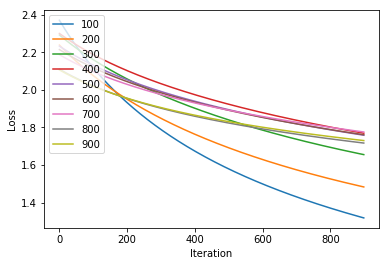

In [66]:
for i in range(0,len(cost_collection)):
    plt.plot(cost_collection[i][100:])
plt.legend(['100', '200', '300', '400', '500', '600','700','800','900'], loc='upper left')
plt.xlabel('Iteration')
plt.ylabel('Loss')
#plt.show()
#plt.savefig('different_training_pairs.png')
plt.savefig('pairs_diff.png', bbox_inches='tight')

In [315]:
with open('trans_matrix.pickle', 'wb') as f:
    pickle.dump(trans_matrix2, f)

In [14]:
len(chcombined[0])

768